In [4]:
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
import matplotlib.pyplot as plt


def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''taylorF2'''
def F_cross(theta,psi,phi):
    return 0.5*(1+np.power(np.cos(theta),2))*np.cos(2*phi)*np.sin(2*psi)-np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)
def F_plus(theta,psi,phi):
    return -0.5*(1+np.power(np.cos(theta),2))*np.cos(2.0*phi)*np.cos(2*psi)-np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
def D_eff(D,theta,psi,phi,iota):
    return D/(np.sqrt(np.power(F_cross(theta,psi,phi),2.0)*np.power(np.cos(iota),2.0)+np.power(F_plus(theta,psi,phi),2)*0.25*(1+np.power(np.cos(iota),2))))
def Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c,v_lso=1/np.sqrt(6.0)):
    Mcal=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal*f,1/3.0)
    return 2*sciconsts.pi*f*t_c-phi_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v/v_lso))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c):
    return np.power(m_c,5.0/6.0)/D_eff(D,theta,psi,phi,iota)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c))
def Psi2(f,m_c,smr,t_c,phi_c):
    Mcal2=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal2*f,1/3.0)
    return 2*sciconsts.pi*f*t_c-phi_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v*np.sqrt(6.0)))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h_mod(f,m_c,smr,t_c,phi_c):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi2(f,m_c,smr,t_c,phi_c))*1e-48
'''vac1(f-stat used)'''
def h_fvac1(f,m_c):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.cos(-0.25*sciconsts.pi+0.75*np.power(8*sciconsts.pi*m_c*f,-5.0/3.0))
'''vac1(f-stat unused)'''
def h_fvac2(f,m_c,phi_c,t_c):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.cos(2*sciconsts.pi*f*t_c+phi_c-0.25*sciconsts.pi+0.75*np.power(8*sciconsts.pi*m_c*f,-5.0/3.0))
'''gas1'''
def h_fgas(f,m_1,m_2,t_0,t_gas):
    s1=k_1cal(m_1,m_2)+1.0/t_gas*np.power(sciconsts.pi*f/np.sqrt(m_1+m_2),-8.0/3.0)
    t_s=t_0-0.25*t_gas*np.log(s1)
    phi_s=sci_integrate.quad(lambda t:2*np.sqrt(m_1+m_2)*np.power((np.exp(4*(t_0-t)/t_gas)-k_1cal(m_1,m_2))*t_gas,-3.0/8.0),0,t_s)[0]
    return 0.5*np.power((1.5/sciconsts.pi),-0.5)*m_1*m_2*(m_1+m_2)*np.power(sciconsts.pi*f,-2.5)*np.power(s1,-0.5)*np.exp(1j*(2*sciconsts.pi*f*t_s-phi_s-0.25*sciconsts.pi))

def h_fgasi(f,m_1,m_2,t_0,t_gas):
    s1=k_1cal(m_1,m_2)+1.0/t_gas*np.power(sciconsts.pi*f/np.sqrt(m_1+m_2),-8.0/3.0)
    t_s=t_0-0.25*t_gas*np.log(s1)
    phi_s=sci_integrate.quad(lambda t:2*np.sqrt(m_1+m_2)*np.power((np.exp(4*(t_0-t)/t_gas)-k_1cal(m_1,m_2))*t_gas,-3.0/8.0),0,t_s)[0]
    return 0.5*np.power((1.5/sciconsts.pi),-0.5)*m_1*m_2*(m_1+m_2)*np.power(sciconsts.pi*f,-2.5)*np.power(s1,-0.5)*np.exp(-1j*(2*sciconsts.pi*f*t_s-phi_s-0.25*sciconsts.pi))

'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)
'''normal maxmum finding method'''
def findmax_0(signal,mc,smr):
    maxff=0
    
    return maxff

In [7]:
fname=sys.argv[0]+'value.txt'
#consts setting
m_sun=1.9891e30/np.power(sciconsts.c,3.0)*sciconsts.G      #c=G=1 mass unit to s
years=365*24*3600.0
#mpc=3.261*sciconsts.light_year#c=G=1 mass unit to s
mpc=3.261*years*1e6
t_scale=4*years
#gas cal
n=10.0
m_1=n*m_sun
m_2=n*m_sun
k_1g=k_1cal(m_1,m_2)
t_gas=1000.0*years
a_0=3.0e8/sciconsts.c
t_0=t_0cal(m_1,m_2,t_gas,a_0)

In [8]:
sci_integrate.quad(lambda t:2*np.sqrt(m_1+m_2)*np.power((np.exp(4*(t_0-t)/t_gas)-k_1cal(m_1,m_2))*t_gas,-3.0/8.0),0,4*years)

(2510057.02286483, 2.7867230999066075e-08)

In [9]:
f=0.003177
(t_0-0.25*t_gas*np.log(k_1cal(m_1,m_2)+1.0/t_gas*np.power(sciconsts.pi*f/np.sqrt(m_1+m_2),-8.0/3.0)))/years

3.9315730228404719

In [10]:
figas=freq_tgas(0,m_1,m_2,t_gas,t_0)
ffgas=freq_tgas(t_scale,m_1,m_2,t_gas,t_0)
print figas,ffgas

0.003156510627 0.00317735806082


In [35]:
f=np.linspace(figas,ffgas,10000)
hfg=np.zeros(10000,dtype='complex128')
i=0
while i<10000:
    hfg[i]=h_fgas(f[i],m_1,m_2,t_0,t_gas)/10/mpc
    i=i+1

In [11]:
A=np.sqrt(sci_integrate.quad(lambda f:4*np.power(abs(h_fgas(f,m_1,m_2,t_0,t_gas)),2.0)/S_n_lisa(f),figas,ffgas)[0])
A

1987545410843922.8

In [12]:
B=np.sqrt(sci_integrate.quad(lambda f:4*np.power(np.power(37.2*m_sun,5.0/6.0)*np.power(f,-7.0/6.0),2.0)/S_n_lisa(f),figas,ffgas)[0])
B

4.2246012267043002e+17

In [ ]:
sci_integrate.quad(lambda f:4*(h_fgasi(f,m_1,m_2,t_0,t_gas)*h_fvac1(f,37.2*m_sun)).real/S_n_lisa(f),0.0001,0.001,limit=10000000)

In [117]:
N2=100000
f=np.linspace(figas,ffgas,N2)
work1=np.zeros(N2,dtype='complex128')
i=0
while i<N2:
    work1[i]=h_fgasi(f[i],m_1,m_2,t_0,t_gas)*h_fvac1(f[i],37.2*m_sun)/S_n_lisa(f[i])
    i=i+1
work2=2.0/N2*abs(fft.fft(work1))[0:N2/2]
AB=work2.max()*2
print AB

1.19850603009e+37


In [118]:
AB/A/B

14273.728854126175

In [ ]:
np.sqrt(sci_integrate.quad(lambda f:4*np.power(hfi(f),2.0)/S_n_lisa(f),figas,ffgas)[0])

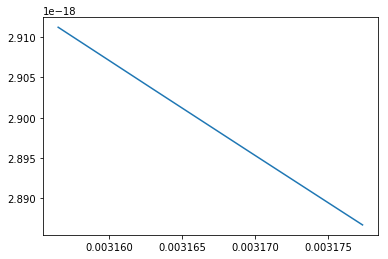

In [36]:
plt.plot(f,abs(hfg))
#plt.plot(f,np.arctan(hfg.imag/hfg.real))
plt.show()

In [3]:
sys.argv[0]

'/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py'